In [9]:
import pandas_datareader as web
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [4]:
# !pip install yfinance

In [5]:
# import yfinance as yf

### Data collection

In [10]:
from google.colab import files

uploaded = files.upload()

Saving bitcoin-2014-09-to-2021-12-20.csv to bitcoin-2014-09-to-2021-12-20 (1).csv


In [6]:
# start = dt.datetime(2013,9,17)
# end = dt.datetime.now()

# data_alt = yf.download('BTC-USD', start, end)
# data_alt.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
# data_alt.to_csv('bitcoin-2014-09-to-2021-12-20.csv')

In [11]:
df = pd.read_csv('/content/bitcoin-2014-09-to-2021-12-20.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [12]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2630,2021-12-16,48900.464844,49425.574219,47529.878906,47665.425781,47665.425781,27268150947
2631,2021-12-17,47653.730469,48004.894531,45618.214844,46202.144531,46202.144531,32902725329
2632,2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690
2633,2021-12-19,46853.867188,48089.664062,46502.953125,46707.015625,46707.015625,25154053861
2634,2021-12-20,46579.351562,47172.265625,46310.511719,46420.980469,46420.980469,27461736448


In [13]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [18]:
df1 = df.reset_index()['Close']

df1

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
2630    47665.425781
2631    46202.144531
2632    46848.777344
2633    46707.015625
2634    46420.980469
Name: Close, Length: 2635, dtype: float64

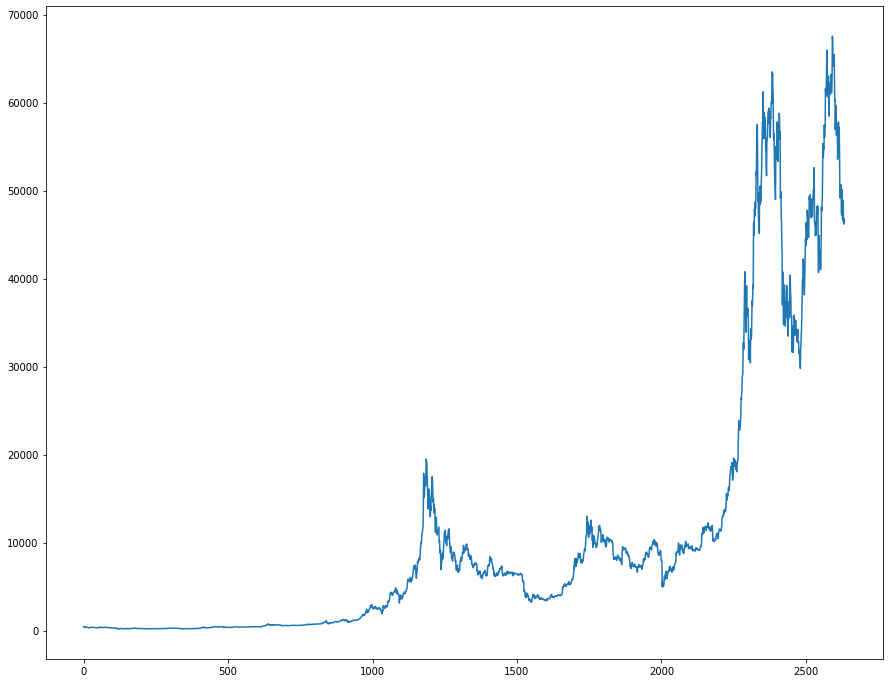

In [19]:
plt.figure(figsize=(15,12))
plt.plot(df1)

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [21]:
print(df1)

[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.69255909]
 [0.69045545]
 [0.6862109 ]]


In [88]:
# save the scaler
import pickle
pickle.dump(scaler, open('scaler-BTC.pkl', 'wb'))

In [22]:
# Spitting dataset into train and test split

training_size = int(len(df1)*0.80)

test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, : ], df1[training_size: len(df1), : 1]

In [23]:
len(train_data), len(test_data)

(2108, 527)

In [24]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i: (i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [25]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(2092, 15)
(2092,)


(None, None)

In [27]:
X_test, y_test = create_dataset(test_data, time_step)
print(X_test.shape), print(y_test.shape)

(511, 15)
(511,)


(None, None)

In [28]:
# reshape the inputs to be [sample, time_steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(2092, 15, 1)

In [29]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(511, 15, 1)

In [30]:
model_0 = Sequential()
model_0.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model_0.add(LSTM(50, return_sequences=True))
model_0.add(LSTM(50))
model_0.add(Dense(1))


model_0.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model_0.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
30/30 [==============================] - 6s 198ms/step - loss: 1.9848e-05 - val_loss: 2.4143e-05
Epoch 2/100
30/30 [==============================] - 2s 57ms/step - loss: 2.0969e-05 - val_loss: 4.3144e-05
Epoch 3/100
30/30 [==============================] - 2s 71ms/step - loss: 1.9960e-05 - val_loss: 2.8276e-05
Epoch 4/100
30/30 [==============================] - 2s 62ms/step - loss: 2.0601e-05 - val_loss: 2.9231e-05
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 2.1841e-05 - val_loss: 2.6239e-05
Epoch 6/100
30/30 [==============================] - 2s 57ms/step - loss: 2.2880e-05 - val_loss: 2.4247e-05
Epoch 7/100
30/30 [==============================] - 2s 51ms/step - loss: 1.9466e-05 - val_loss: 2.4297e-05
Epoch 8/100
30/30 [==============================] - 2s 61ms/step - loss: 2.0725e-05 - val_loss: 3.1346e-05
Epoch 9/100
30/30 [==============================] - 2s 56ms/step - loss: 1.9470e-05 - val_loss: 2.5837e-05
Epoch 10/100
30/30 [=======

In [67]:
model_0.save('BTC-lstm.h5')

In [60]:
train_predict = model_0.predict(X_train)
test_predict = model_0.predict(X_test)

In [61]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [62]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

5860.977255505161

In [63]:
math.sqrt(mean_squared_error(y_test, test_predict))

36572.232467270755

In [64]:
# !pip install mpld3

In [65]:
import mpld3
from mpld3 import plugins

In [66]:
%matplotlib notebook
# shift train predictions for plotting
look_back = 15
plt.figure(figsize=(20,18))
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15,12))
l1 = ax.plot(scaler.inverse_transform(df1))
l2 = ax.plot(trainPredictPlot)
l3 = ax.plot(testPredictPlot)

line_collections = [l1, l2, l3]
legends = ['Real', 'TrainPredict', 'TestPredict']
plugins.connect(fig, plugins.InteractiveLegendPlugin(line_collections, legends))

mpld3.display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
# data for prediction
pred_input = np.array(df['Close'].iloc[-16:-1])
pred_input_shaped = pred_input.reshape(-1, 1)

In [96]:
pred_input_shaped.shape

(15, 1)

In [89]:
loaded_scaler = pickle.load(open('/content/scaler-BTC.pkl', 'rb'))

In [103]:
transformed_input = loaded_scaler.transform(pred_input_shaped)
transformed_input.shape

(15, 1)

In [104]:
x_input = transformed_input.reshape(1, transformed_input.shape[0], transformed_input.shape[1])
x_input.shape

(1, 15, 1)

In [106]:
# Prediction for today day
yhat = model_0.predict(x_input)
print(loaded_scaler.inverse_transform(yhat))

[[41496.184]]


In [107]:
df['Close'].iloc[-1]

46420.98046875